In [1]:
# Import library

import numpy as np
import pandas as pd
pd.set_option('future.no_silent_downcasting', True)
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from xgboost import XGBClassifier
import matplotlib.pyplot as plt

## Import data

In [2]:
# Load the datasets
train_data = pd.read_csv('Data/Loan_dataset_train.csv') # This is the portion of the dataset used to "train" or fit the model.
test_data = pd.read_csv('Data/Loan_dataset_test.csv') # This subset is reserved for evaluating the model’s performance after training.

In [3]:
# Display the first few rows of the training dataset
print("Training Data Head:")
train_data.head()

Training Data Head:


,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [4]:
# # Display the first few rows of the test dataset
print("\nTest Data Head:")
test_data.head()


Test Data Head:


,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area
0,LP001015,Male,Yes,0,Graduate,No,5720,0,110.0,360.0,1.0,Urban
1,LP001022,Male,Yes,1,Graduate,No,3076,1500,126.0,360.0,1.0,Urban
2,LP001031,Male,Yes,2,Graduate,No,5000,1800,208.0,360.0,1.0,Urban
3,LP001035,Male,Yes,2,Graduate,No,2340,2546,100.0,360.0,NaN,Urban
4,LP001051,Male,No,0,Not Graduate,No,3276,0,78.0,360.0,1.0,Urban


## Understanding the data

In [5]:
# Data columns
train_data.columns

Index(['Loan_ID', 'Gender', 'Married', 'Dependents', 'Education',
       'Self_Employed', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'Property_Area', 'Loan_Status'],
      dtype='object')

There are 12 independent variables and 1 target variable, i.e., `Loan_Status`

In [6]:
# Data columns
test_data.columns

Index(['Loan_ID', 'Gender', 'Married', 'Dependents', 'Education',
       'Self_Employed', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'Property_Area'],
      dtype='object')

The test dataset contains the same features as the training dataset, except for `Loan_Status`. The model will be trained on the training data to predict `Loan_Status` for the test dataset.

The description of each variable is provided below.

| Variable           | Description                                  |
|--------------------|----------------------------------------------|
| Loan_ID            | Unique Loan ID                               |
| Gender             | Male/ Female                                 |
| Married            | Applicant married (Y/N)                      |
| Dependents         | Number of dependents                         |
| Education          | Applicant Education (Graduate/Under Graduate)|
| Self_Employed      | Self employed (Y/N)                          |
| ApplicantIncome    | Applicant income                             |
| CoapplicantIncome  | Coapplicant income                           |
| LoanAmount         | Loan amount in thousands                     |
| Loan_Amount_Term   | Term of loan in months                       |
| Credit_History     | Creof individual’s repayment of their debts guidelines              |
| Property_Area      | Urban/ Semi Urban/ Rural                     |
| Loan_Status        | Loan approved (Y/N)                          |


In [7]:
# Dataset shape
train_data.shape, test_data.shape

((614, 13), (367, 12))

The training dataset contains 614 rows and 13 columns, while the test dataset includes 367 rows and 12 columns.

In [8]:
# Remove the Loan_ID variable since it doesn't impact the loan status. 

train_data = train_data.drop('Loan_ID', axis=1)
test_data = test_data.drop('Loan_ID', axis=1)

## Data Exploration
Expanding on the exploratory analysis will allow to better understand the data distribution, feature relationships, and key patterns.

### Univariate analysis
This part focuses on examining each feature individually, understanding the distribution of categorical and numerical variables, and identifying potential outliers.

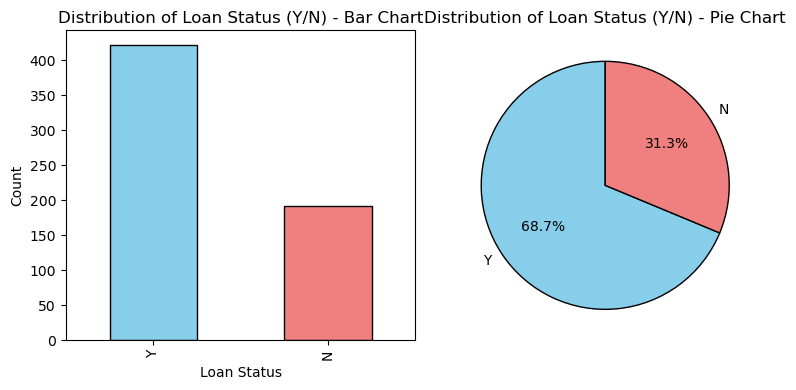

In [9]:
# Bar chart and pie chart
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

# Bar chart for 'Loan_Status' distribution

# Counting the values for 'Loan_Status'
loan_status_counts = train_data['Loan_Status'].value_counts()
# Calculating percentages for pie chart
total = loan_status_counts.sum()
loan_status_percentages = (loan_status_counts / total) * 100

loan_status_counts.plot.bar(ax=axes[0], color=['skyblue', 'lightcoral'], edgecolor='black')
axes[0].set_title('Distribution of Loan Status (Y/N) - Bar Chart')
axes[0].set_xlabel('Loan Status')
axes[0].set_ylabel('Count')

# Pie chart for 'Loan_Status' distribution
axes[1].pie(loan_status_percentages, labels=loan_status_counts.index, autopct='%1.1f%%', startangle=90, 
            colors=['skyblue', 'lightcoral'], wedgeprops={'edgecolor': 'black'})
axes[1].set_title('Distribution of Loan Status (Y/N) - Pie Chart')

# Displaying the combined plot
plt.tight_layout()
plt.show()

The distribution plot shows that the target variable, `Loan_Status`, has more approved loans (labeled as Y) than disapproved ones (labeled as N). 68.7% had received loan approval, while 31.3% were rejected.

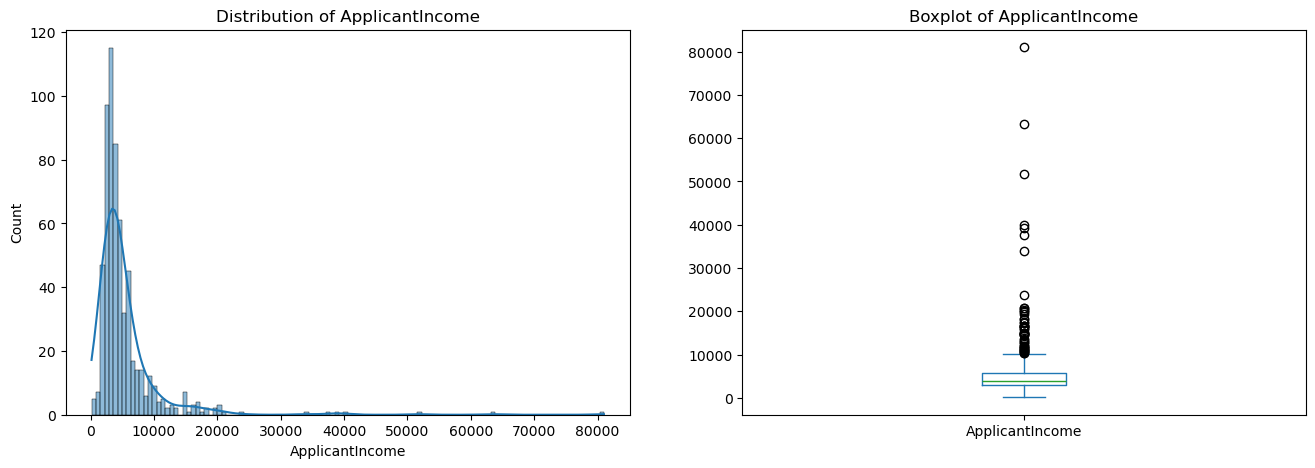

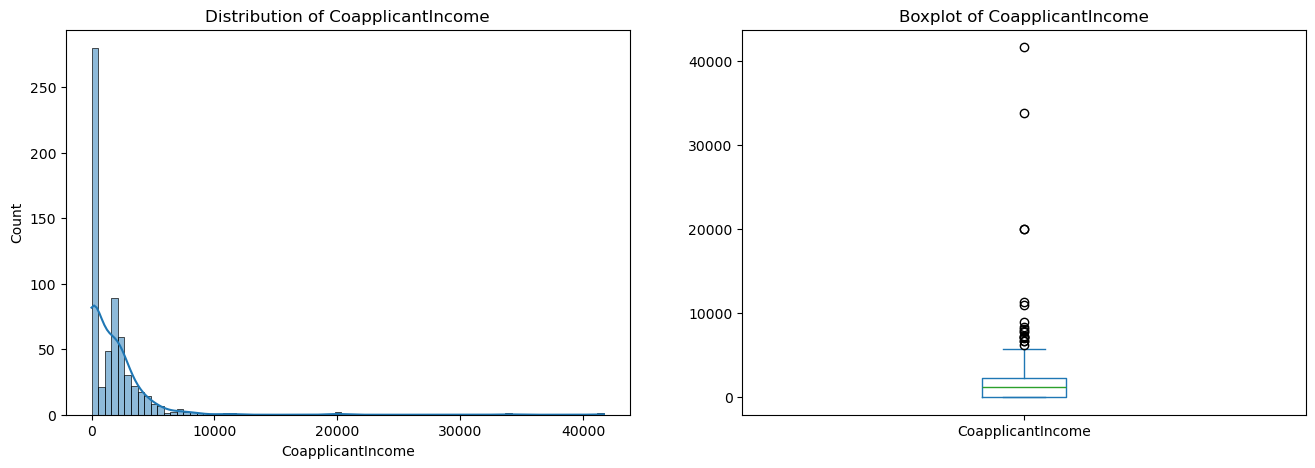

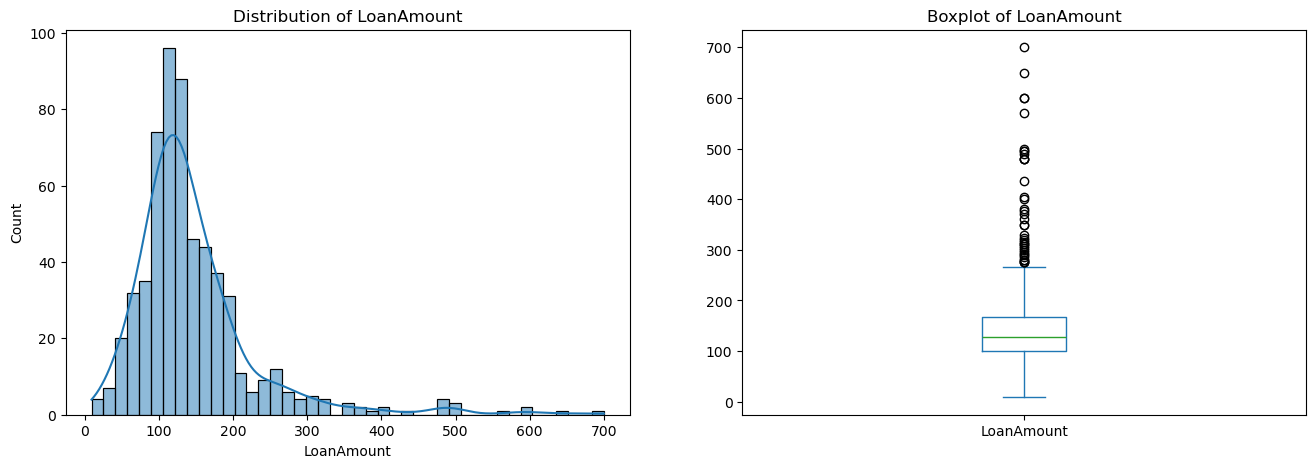

In [10]:
# Distributions of numerical features

# List of numerical columns
numerical_columns = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount'] 

# Loop through each column to create distribution and boxplots
for column in numerical_columns:
    plt.figure(figsize=(16, 5))
    
    # Distribution plot
    plt.subplot(1, 2, 1)
    sns.histplot(train_data[column], kde=True)  
    plt.title(f'Distribution of {column}')
    
    # Boxplot
    plt.subplot(1, 2, 2)
    train_data[column].plot.box()
    plt.title(f'Boxplot of {column}')
    
    plt.show()

The histograms show that the distribution of `ApplicantIncome` and `CoapplicantIncome` are right-skewed, indicating that a few applicants have significantly higher incomes than others. This skewness might necessitate scaling or transformation for more effective modeling. 
Additionally, `LoanAmount` also exhibits a similar right-skewed distribution.
There are also some outliers that will be addressed in later sections.

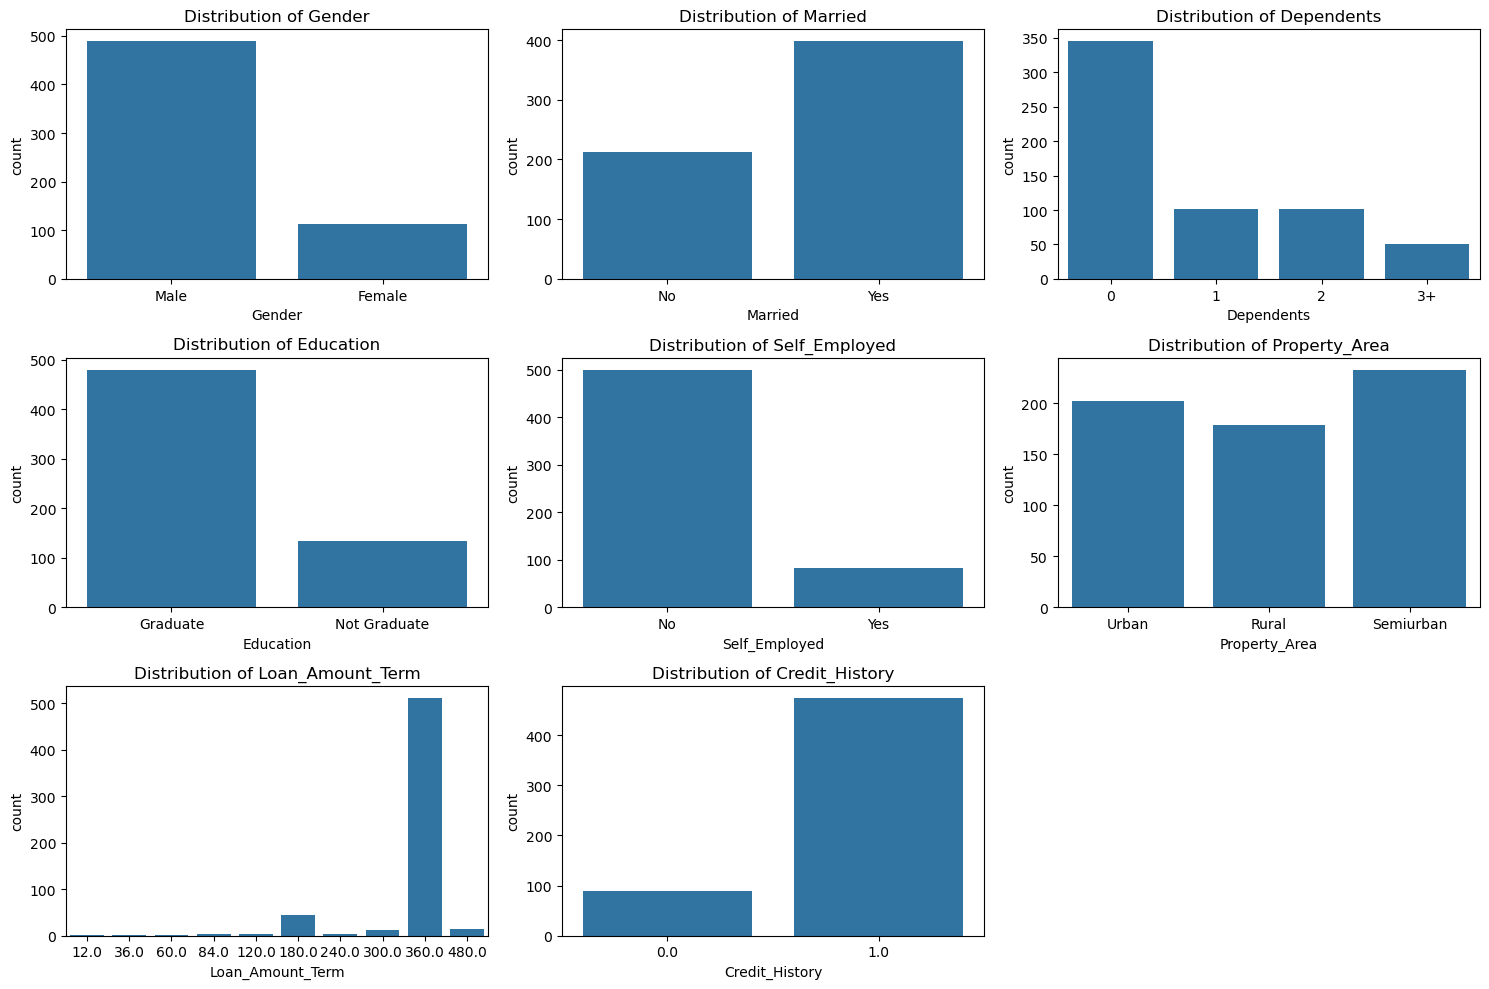

In [11]:
# Distributions of categorical features

# List of categorical columns
categorical_features = ['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Property_Area', 'Loan_Amount_Term', 'Credit_History']

# Plot through each column
plt.figure(figsize=(15, 10))
for i, column in enumerate(categorical_features, 1):
    plt.subplot(3, 3, i)
    sns.countplot(data=train_data, x=column)
    plt.title(f'Distribution of {column}')
plt.tight_layout()
plt.show()

The count plots reveal key characteristics of the categorical features:

- `Gender` and `Married`: The majority of applicants are male and married.
- `Dependents`: There is a higher proportion of applicants without dependents, with fewer applicants reporting multiple dependents.
- `Education`: Most applicants are graduates.
- `Self_Employed`: Fewer applicants are self-employed, which might be a distinguishing characteristic among applicants.
- `Credit_History`: The majority of applicants have repaid their debts
- `Property_Area`: The distribution is fairly balanced across *Rural*, *Urban*, and *Semiurban* areas, potentially aiding in differentiating loan outcomes based on geographic context.

### Bivariate Analysis

Bivariate analysis explores the relationship between each feature and the target variable, allowing to examine potential correlations or patterns.


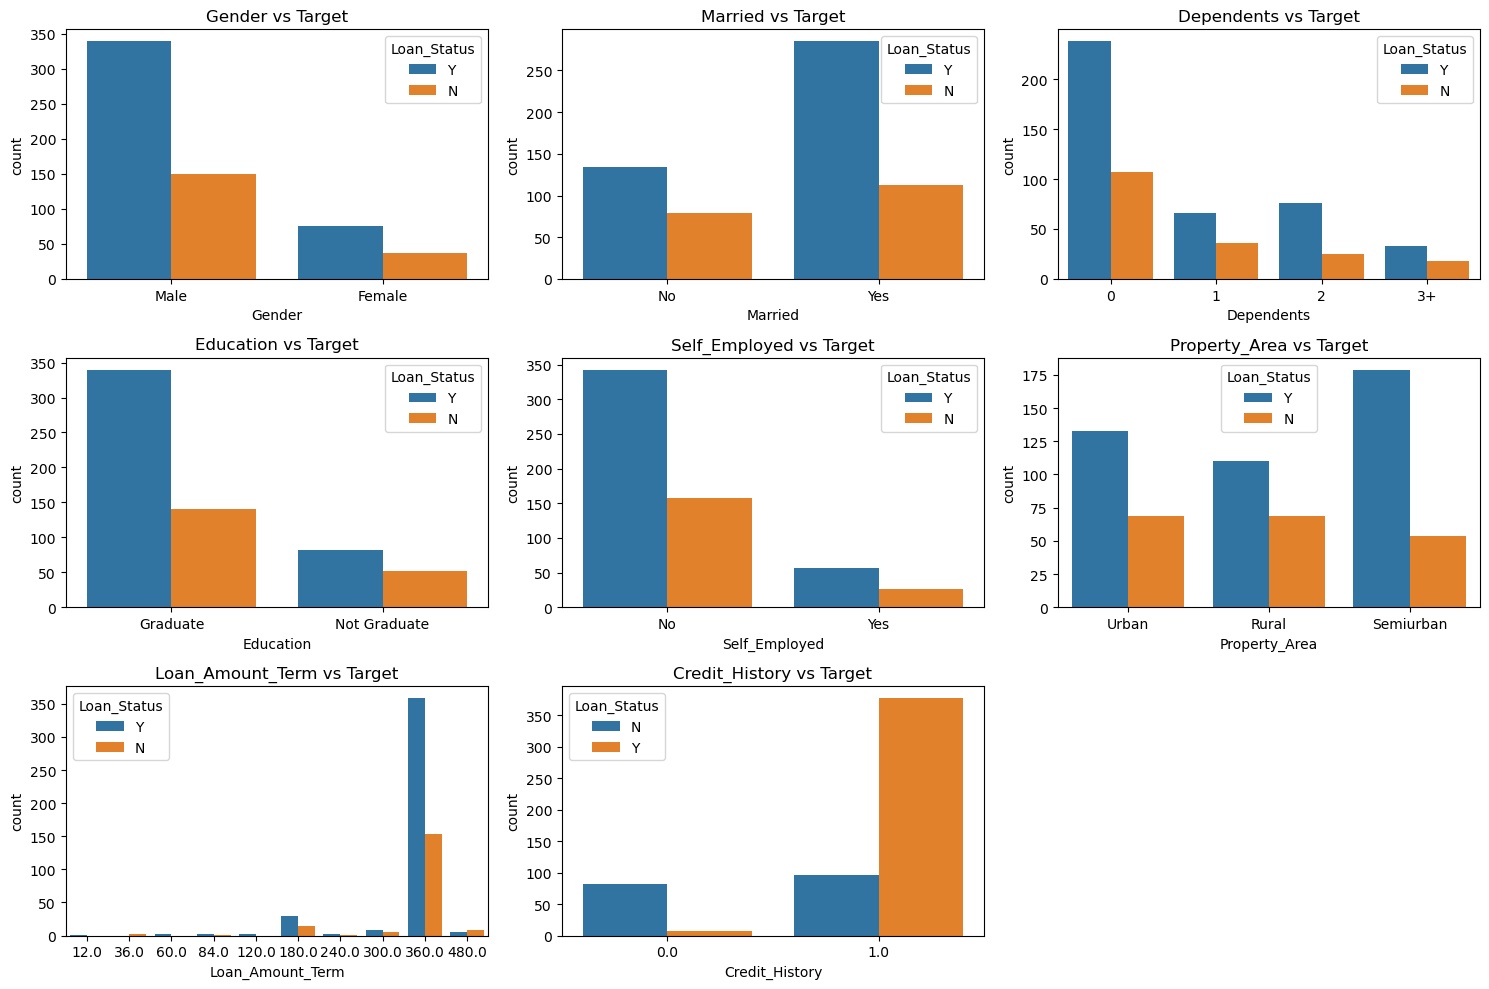

In [12]:
# Countplots for categorical features with respect to target
plt.figure(figsize=(15, 10))
for i, column in enumerate(categorical_features, 1):
    plt.subplot(3, 3, i)
    sns.countplot(data=train_data, x=column, hue='Loan_Status')  
    plt.title(f'{column} vs Target')
plt.tight_layout()
plt.show()

The count plots for categorical features reveal key relationships with loan approval status (`Loan_Status`). Here’s a summary of the insights:

- Male and married applicants have slightly higher loan approval rates, though this difference is minor.
- Applicants with fewer dependents appear to have slightly better approval rates.
- Graduates show higher loan approval rates than non-graduates.
- Non-self-employed applicants have higher approval rates.
- Applicants with a credit history (recorded as 1.0) show a significantly higher loan approval rate, indicating it is a strong predictor.
- Approval rates are higher in *Semiurban* areas compared to *Urban* and *Rural* areas. 

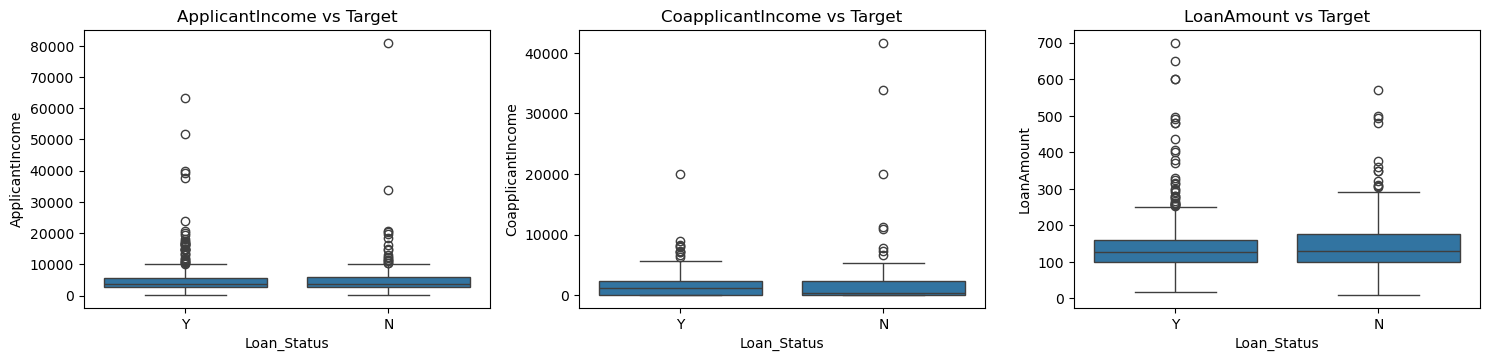

In [13]:
# Boxplots to analyze numerical features against the target variable

plt.figure(figsize=(15, 10))
for i, column in enumerate(numerical_columns, 1):
    plt.subplot(3, 3, i)
    sns.boxplot(data=train_data, x='Loan_Status', y=column)  
    plt.title(f'{column} vs Target')
plt.tight_layout()
plt.show()

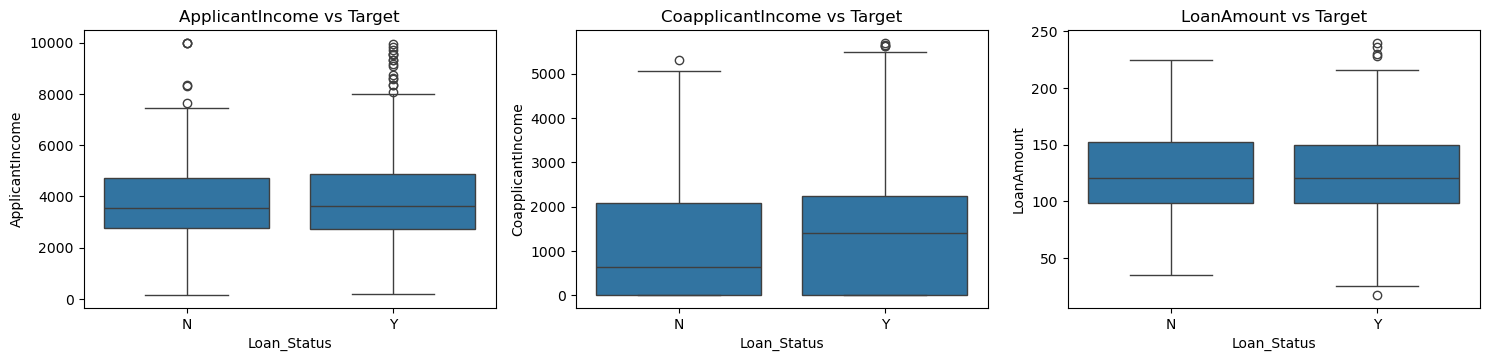

In [14]:
# Function to remove outliers based on IQR
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# Remove outliers for each numerical column
filtered_data = train_data.copy()
for column in numerical_columns:
    filtered_data = remove_outliers(filtered_data, column)

# Plot boxplots without outliers
plt.figure(figsize=(15, 10))
for i, column in enumerate(numerical_columns, 1):
    plt.subplot(3, 3, i)
    sns.boxplot(data=filtered_data, x='Loan_Status', y=column)  
    plt.title(f'{column} vs Target')
plt.tight_layout()
plt.show()

The boxplots for numerical features provide insight into their relationship with loan approval status (`Loan_Status`). Here is a summary of the observed patterns:

- Approved and not approved loans for `ApplicantIncome` and `CoapplicantIncome` have similar distributions, though some outliers exist for higher incomes.
- Higher `LoanAmount` values appear in both approved and unapproved loans but with more variability in the not approved group, potentially hinting at an influencing factor.


### Correlation Analysis

Correlation analysis considers the interactions between multiple variables, which can uncover deeper insights about the dataset.

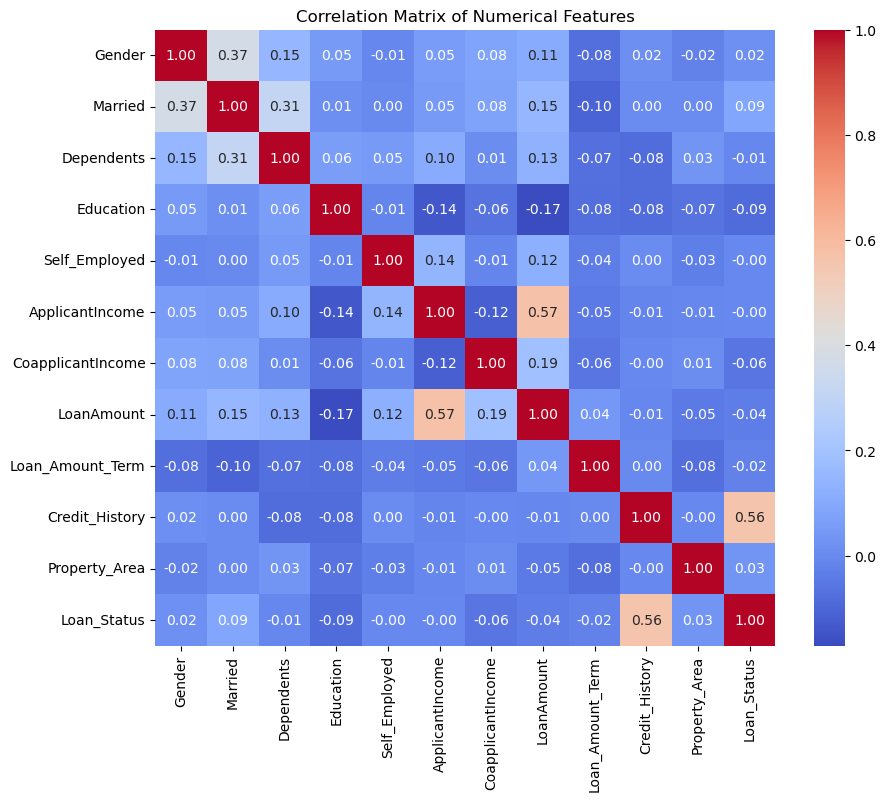

In [15]:
# Correlation matrix for numerical features

#  Prepare data for correlation analysis
train_data['Loan_Status'] = train_data['Loan_Status'].replace({'Y': 1, 'N': 0})

train_data['Gender'] = train_data['Gender'].replace({'Male': 1, 'Female': 0})
test_data['Gender'] = test_data['Gender'].replace({'Male': 1, 'Female': 0})

train_data['Married'] = train_data['Married'].replace({'Yes': 1, 'No': 0})
test_data['Married'] = test_data['Married'].replace({'Yes': 1, 'No': 0})

train_data['Self_Employed'] = train_data['Self_Employed'].replace({'Yes': 1, 'No': 0})
test_data['Self_Employed'] = test_data['Self_Employed'].replace({'Yes': 1, 'No': 0})

# Property_Area, Dependents, Education has multiple values
encode_columns = ['Property_Area', 'Dependents', 'Education']
le = LabelEncoder()
for col in encode_columns:
    train_data[col] = le.fit_transform(train_data[col])
    test_data[col] = le.transform(test_data[col])

plt.figure(figsize=(10, 8))
sns.heatmap(train_data.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Numerical Features')
plt.show()


The correlation matrix provides insights into the relationships between various numerical features in the dataset with a focus on predicting the `Loan_Status`. Here are the key observations:

1. **Loan Status Correlations**:
   - `Credit_History` shows the highest positive correlation with `Loan_Status` (0.56), suggesting that credit history is a significant factor in determining loan approval.
   - `Married` has a slight positive correlation (0.09) with `Loan_Status`, but this relationship is weak and may not be particularly influential in predictions.
   - Other features like `ApplicantIncome`, `CoapplicantIncome`, and `LoanAmount` have very minimal correlations with `Loan_Status`, indicating they might have a limited direct impact.

2. **Feature Interdependencies**:
   - `ApplicantIncome` and `LoanAmount` have a moderately positive correlation (0.57), which makes sense as higher incomes often allow for larger loan amounts.
   - `LoanAmount` also has a weak positive correlation with `CoapplicantIncome` (0.19), showing some connection but not as strong as with `ApplicantIncome`.
   - `Married` and `Dependents` have a positive correlation (0.31), which aligns with the likelihood of having more dependents after marriage.

3. **Negligible Correlations**:
   - Many features, such as `Gender`, `Education`, `Self_Employed`, and `Property_Area`, exhibit very low or near-zero correlations with `Loan_Status`, suggesting that these factors may not play a crucial role in predicting loan approval.
   - `Loan_Amount_Term` and most other features have near-zero correlations with each other, showing minimal interdependencies.

4. **Insights for Predictive Modeling**:
   - Given the high correlation between `Credit_History` and `Loan_Status`, `Credit_History` should be a primary feature in the model.
   - Other features with minimal correlation may not significantly contribute to predicting `Loan_Status` and could be reconsidered during feature selection to snr larger loan amounts.


## Missing Value and Outlier Treatment
Identifying missing values and outliers aims to improve data quality by ensuring accuracy and reliability, as these issues can skew analysis and lead to incorrect conclusions. Addressing them helps build robust models and derive meaningful insights from the data.


In [16]:
# Check for missing values
train_data.isnull().sum()

Gender               13
Married               3
Dependents            0
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

In [17]:
# Check for missing values
test_data.isnull().sum()

Gender               11
Married               0
Dependents            0
Education             0
Self_Employed        23
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount            5
Loan_Amount_Term      6
Credit_History       29
Property_Area         0
dtype: int64

In [18]:
# Fill or drop missing values as necessary
# For example, filling categorical missing values with the mode and numerical with the median
for column in train_data.columns:
    if column in  categorical_features:
        train_data[column] = train_data[column].fillna(train_data[column].mode()[0])
        test_data[column] = train_data[column].fillna(train_data[column].mode()[0])
    else:
        train_data[column] = train_data[column].fillna(train_data[column].median())
        test_data[column] = train_data[column].fillna(train_data[column].median())

Apply the log transformation to right-skewed column distributions: smaller values are only minimally impacted, while larger values are substantially reduced, resulting in a distribution that more closely resembles a normal distribution. This transformation mitigates the influence of extreme values, making the distribution more symmetric and suitable for modeling.

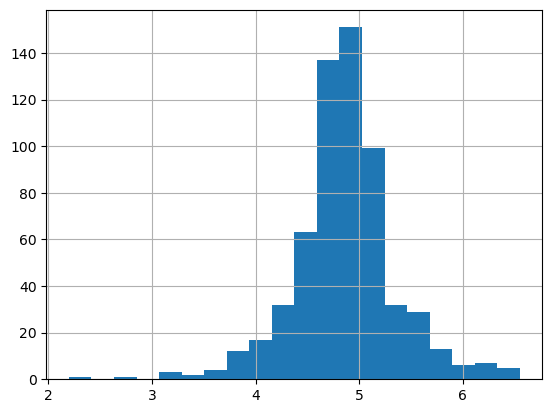

In [19]:
# Loan Amount
train_data['LoanAmount_log'] = np.log(train_data['LoanAmount']) 
train_data['LoanAmount_log'].hist(bins=20) # effect of log transformation
test_data['LoanAmount_log'] = np.log(test_data['LoanAmount'])

`ApplicantIncome` and `CoapplicantIncome` include zero values. Since a log transformation requires positive values, a small constant can be added to shift the data

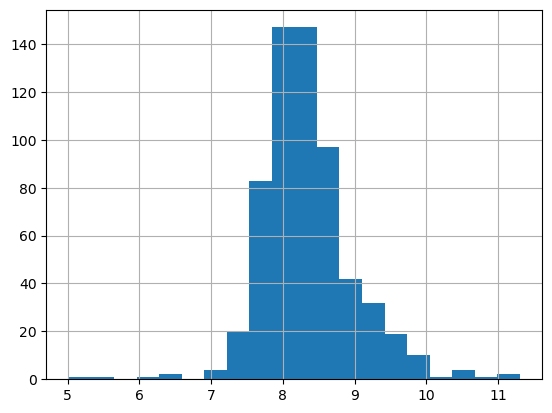

In [20]:
# ApplicantIncome
c = 1
train_data['ApplicantIncome_log'] = np.log(train_data['ApplicantIncome'] + c) 
train_data['ApplicantIncome_log'].hist(bins=20) # effect of log transformation
test_data['ApplicantIncome_log'] = np.log(test_data['ApplicantIncome'] + c)

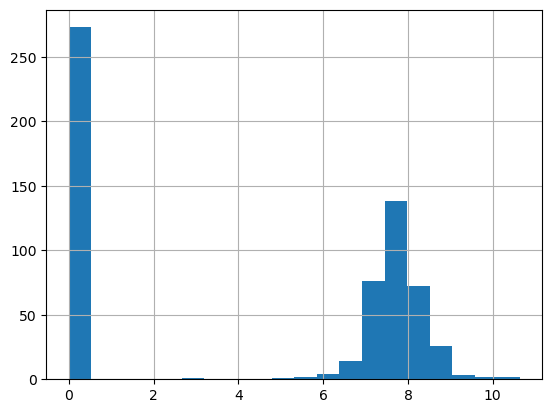

In [21]:
# CoapplicantIncome
train_data['CoapplicantIncome_log'] = np.log(train_data['CoapplicantIncome'] + c) 
train_data['CoapplicantIncome_log'].hist(bins=20) # effect of log transformation
test_data['CoapplicantIncome_log'] = np.log(test_data['CoapplicantIncome'] + c)

## Feature Engineering

To enhance our model's predictive power, new features are introduced based on our domain knowledge (for more details see this conference [paper](https://doi.org/10.1051/itmconf/20224403019)). These features are designed to influence the target variable, loan approval likelihood, as follows:

1. **Total Income**  
   - By combining the `Applicant Income` and `Co-applicant Income`, we create a `Total Income` feature. Higher total income may correlate with a higher probability of loan approval, as it indicates greater financial capability. 

2. **EMI (Equated Monthly Installment)**  
   - EMI represents the fixed monthly payment required to repay the loan over the specified term. EMI is the ratio of the loan amount to the loan term. Applicants with a high EMI might experience more financial strain, potentially lowering their ability to keep up with payments.

3. **Balance Income**  
   - This feature captures the income remaining after the EMI has been deducted. We hypothesize that a higher balance income enhances the likelihood of loan repayment, as it suggests sufficient funds are available even after covering loan payments, increasing the chances of loan approval.

In [22]:
# Total Income
train_data['Total_Income']=train_data['ApplicantIncome']+train_data['CoapplicantIncome']
test_data['Total_Income']=test_data['ApplicantIncome']+test_data['CoapplicantIncome']

# EMI
train_data['EMI']=train_data['LoanAmount']/train_data['Loan_Amount_Term'] 
test_data['EMI']=test_data['LoanAmount']/test_data['Loan_Amount_Term']

# Balance Income
train_data['Balance_Income']=train_data['Total_Income']-(train_data['EMI']*1000) 
test_data['Balance_Income']=test_data['Total_Income']-(test_data['EMI']*1000)

Remove the variables used to create these new features, as they will likely be highly correlated with the new features. 

In [23]:
train_data=train_data.drop(['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term'], axis=1)
test_data=test_data.drop(['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term'], axis=1)

## Machine Learning Model

In [26]:
# Prepare data for feeding into the model
X = train_data.drop('Loan_Status', axis=1) 
y = train_data.Loan_Status.astype(int)

In [27]:
# Initialize the logistic regression model as a basaline method
LR_model = LogisticRegression(max_iter=1000)

# Define 10-fold stratified cross-validator
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=27)

# Perform cross-validation and collect accuracy for each fold
accuracies = cross_val_score(LR_model, X, y, cv=skf, scoring='accuracy')

# Print mean and standard deviation of accuracy
print(f"\nMean Accuracy: {accuracies.mean():.4f}")

Fold 1: Accuracy = 0.8226
Fold 2: Accuracy = 0.7903
Fold 3: Accuracy = 0.8065
Fold 4: Accuracy = 0.6613
Fold 5: Accuracy = 0.7869
Fold 6: Accuracy = 0.8197
Fold 7: Accuracy = 0.8033
Fold 8: Accuracy = 0.6885
Fold 9: Accuracy = 0.6885
Fold 10: Accuracy = 0.8033

Mean Accuracy: 0.7671


In [28]:
# Advanced methods to improve accuracy

# Support Vector Machine (SVM)
svm_params = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}
svm_model = SVC()
svm_grid = GridSearchCV(svm_model, svm_params, cv=skf, scoring='accuracy')
svm_grid.fit(X, y)
print("Best SVM Parameters:", svm_grid.best_params_)
print("Best SVM Accuracy:", svm_grid.best_score_)

KeyboardInterrupt: 

In [ ]:
# Random Forest
rf_params = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}
rf_model = RandomForestClassifier(random_state=42)
rf_grid = GridSearchCV(rf_model, rf_params, cv=skf, scoring='accuracy')
rf_grid.fit(X, y)
print("Best Random Forest Parameters:", rf_grid.best_params_)
print("Best Random Forest Accuracy:", rf_grid.best_score_)

In [ ]:
# XGBoost
xgb_params = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 6, 10]
}
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_grid = GridSearchCV(xgb_model, xgb_params, cv=skf, scoring='accuracy')
xgb_grid.fit(X, y)
print("Best XGBoost Parameters:", xgb_grid.best_params_)
print("Best XGBoost Accuracy:", xgb_grid.best_score_)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Plot feature importances for Random Forest
def plot_rf_feature_importance(model, feature_names):
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]
    
    plt.figure(figsize=(10, 6))
    plt.title("Random Forest Feature Importances")
    plt.bar(range(len(importances)), importances[indices], align="center")
    plt.xticks(range(len(importances)), [feature_names[i] for i in indices], rotation=90)
    plt.tight_layout()
    plt.show()

# Plot feature importances for XGBoost
def plot_xgb_feature_importance(model, feature_names):
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]
    
    plt.figure(figsize=(10, 6))
    plt.title("XGBoost Feature Importances")
    plt.bar(range(len(importances)), importances[indices], align="center")
    plt.xticks(range(len(importances)), [feature_names[i] for i in indices], rotation=90)
    plt.tight_layout()
    plt.show()

# Retrieve and plot feature importances for the best Random Forest model
best_rf_model = rf_grid.best_estimator_
feature_names = [f"Feature {i}" for i in range(X.shape[1])]  # Assumes generic feature names; replace as necessary
plot_rf_feature_importance(best_rf_model, feature_names)

# Retrieve and plot feature importances for the best XGBoost model
best_xgb_model = xgb_grid.best_estimator_
plot_xgb_feature_importance(best_xgb_model, feature_names)
